# RAGAS로 평가한 5개의 RAG 시스템 성능 시각화

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import os
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

print("📊 시각화 라이브러리 로드 완료!")


📊 시각화 라이브러리 로드 완료!


In [2]:
# RAGAS 결과 데이터 로드 및 통합
def load_ragas_results():
    """개별 CSV 파일들로부터 RAGAS 결과를 로드하고 통합"""
    
    # 결과 파일 경로
    result_dir = "Reranker_RAGAS_result"
    
    # 각 리랭커별 결과 파일 정보
    reranker_files = {
        "BM25 기본": f"{result_dir}/bm25_ragas_evaluation_20250914_182955.csv",
        "Cohere": f"{result_dir}/cohere_ragas_evaluation_20250914_173928.csv", 
        "Hybrid CombSum": f"{result_dir}/hybrid_combsum_ragas_evaluation_20250914_220606.csv",
        "LLM 기본": f"{result_dir}/llm_ragas_evaluation_20250915_042248.csv",
        "Legal Rule Boost": f"{result_dir}/rule_ragas_evaluation_20250915_192346.csv"
    }
    
    # 통합 데이터프레임 생성
    all_results = []
    
    for reranker_name, file_path in reranker_files.items():
        try:
            df = pd.read_csv(file_path, index_col=0)
            if len(df) > 0:
                # 첫 번째 행의 데이터 추출
                row_data = df.iloc[0].to_dict()
                row_data['reranker'] = reranker_name
                all_results.append(row_data)
                print(f"✅ {reranker_name}: 데이터 로드 완료")
            else:
                print(f"⚠️ {reranker_name}: 빈 파일")
        except Exception as e:
            print(f"❌ {reranker_name}: 파일 로드 실패 - {e}")
    
    # 데이터프레임 생성
    results_df = pd.DataFrame(all_results)
    
    # 컬럼 순서 정리
    metric_columns = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy', 'overall_score']
    results_df = results_df[['reranker'] + metric_columns]
    
    # 메트릭 값들을 소수점 4자리로 반올림
    for col in metric_columns:
        results_df[col] = results_df[col].round(4)
    
    print(f"\n📊 총 {len(results_df)}개 리랭커 결과 통합 완료")
    return results_df

# 데이터 로드
ragas_df = load_ragas_results()
print("\n🔍 통합된 RAGAS 결과:")
print(ragas_df)


✅ BM25 기본: 데이터 로드 완료
✅ Cohere: 데이터 로드 완료
✅ Hybrid CombSum: 데이터 로드 완료
✅ LLM 기본: 데이터 로드 완료
✅ Legal Rule Boost: 데이터 로드 완료

📊 총 5개 리랭커 결과 통합 완료

🔍 통합된 RAGAS 결과:
           reranker  context_precision  context_recall  faithfulness  \
0           BM25 기본             0.6211             1.0        0.3333   
1            Cohere             0.9750             1.0        1.0000   
2    Hybrid CombSum             0.9765             1.0        0.0000   
3            LLM 기본             0.6428             1.0        1.0000   
4  Legal Rule Boost             0.5566             1.0        1.0000   

   answer_relevancy  overall_score  
0            0.8827         0.7093  
1            0.8827         0.9644  
2            0.8827         0.7148  
3            0.8827         0.8814  
4            0.8827         0.8598  


<Figure size 1500x1000 with 0 Axes>

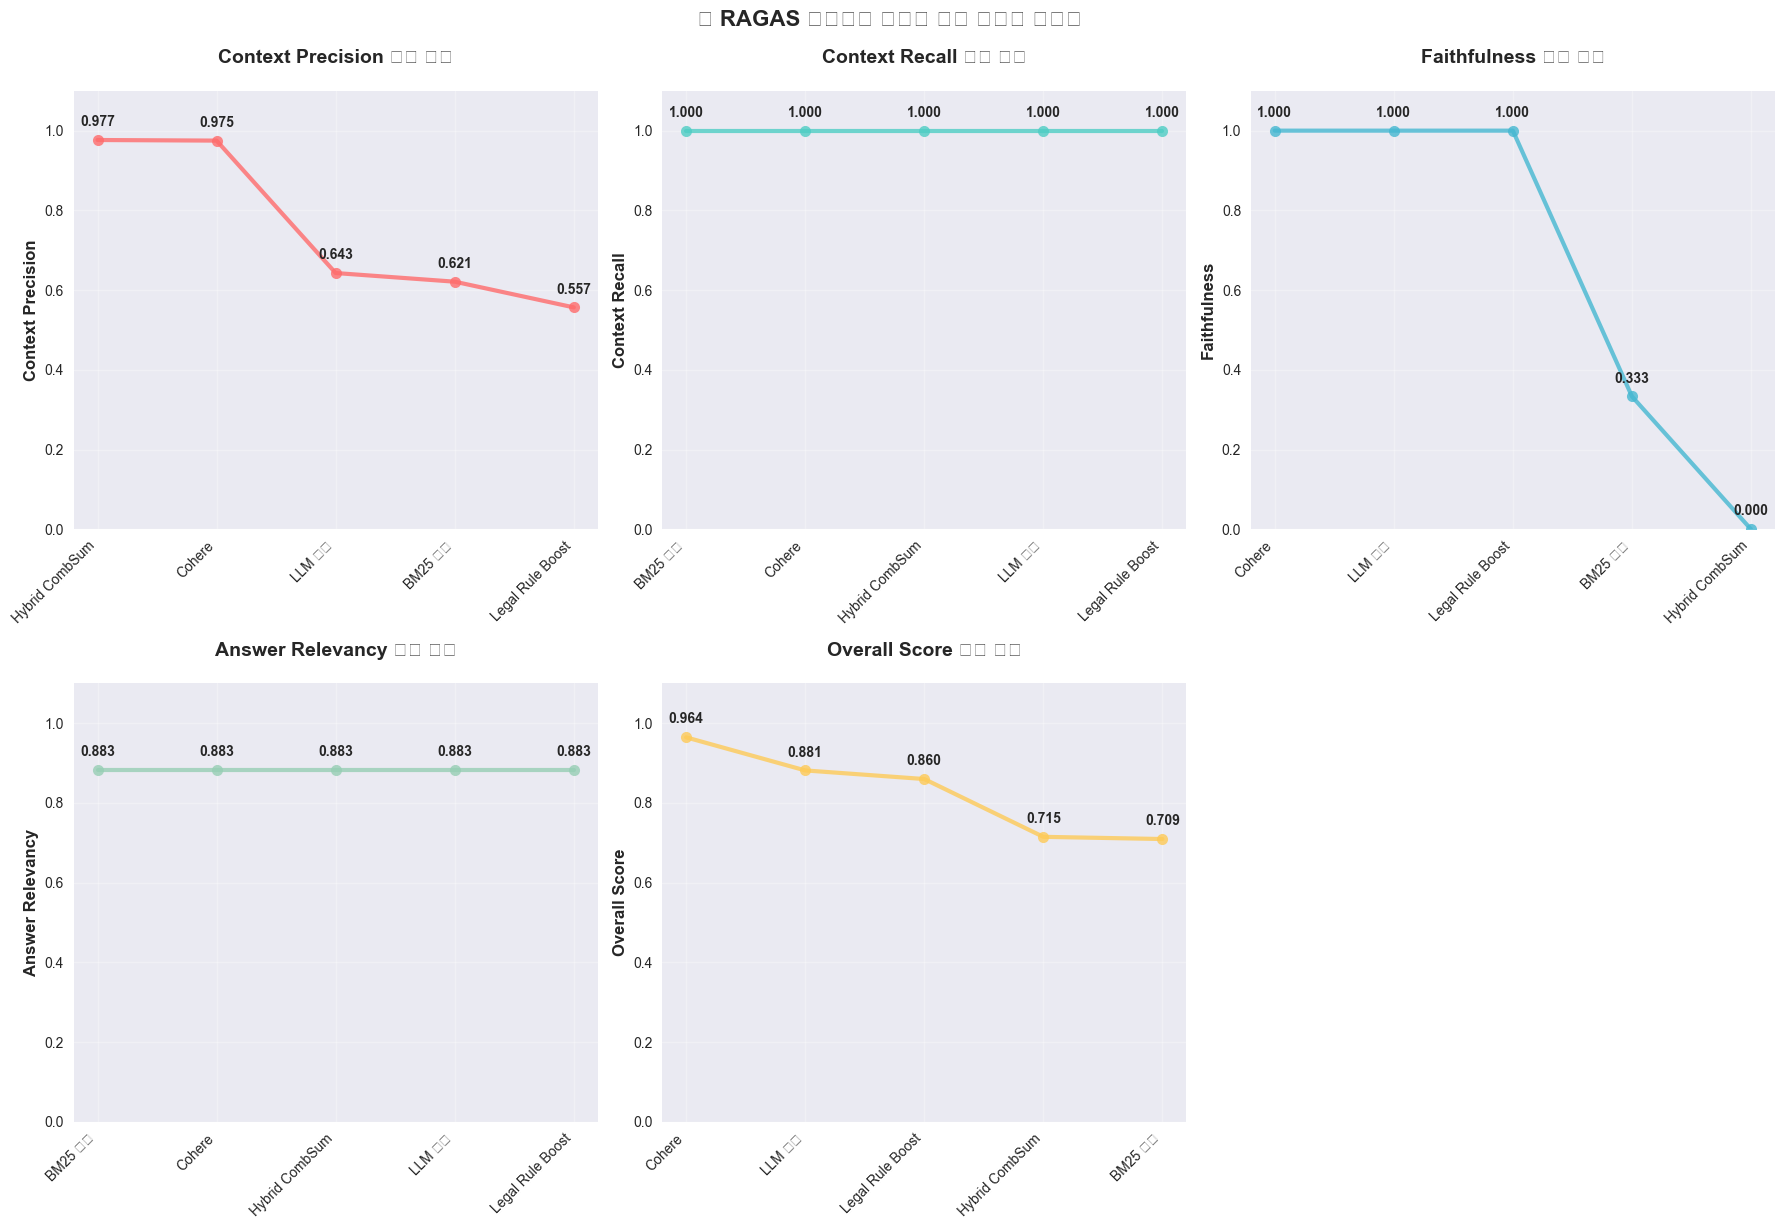

In [3]:
# 1. 꺾은선 그래프 - 메트릭별 성능 비교
def plot_line_chart(df):
    """메트릭별 성능을 꺾은선 그래프로 시각화"""
    
    plt.figure(figsize=(15, 10))
    
    # 메트릭 컬럼들
    metrics = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy', 'overall_score']
    metric_names = ['Context Precision', 'Context Recall', 'Faithfulness', 'Answer Relevancy', 'Overall Score']
    
    # 색상 팔레트
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    
    # 서브플롯 생성
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 각 메트릭별 꺾은선 그래프
    for i, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
        if i < 5:  # 5개 메트릭만
            ax = axes[i]
            
            # 데이터 정렬 (성능 순)
            sorted_df = df.sort_values(metric, ascending=False)
            
            # 꺾은선 그래프
            ax.plot(range(len(sorted_df)), sorted_df[metric], 
                   marker='o', linewidth=3, markersize=8, color=color, alpha=0.8)
            
            # 점에 값 표시
            for j, (idx, row) in enumerate(sorted_df.iterrows()):
                ax.annotate(f'{row[metric]:.3f}', 
                           (j, row[metric]), 
                           textcoords="offset points", 
                           xytext=(0,10), 
                           ha='center', fontsize=10, fontweight='bold')
            
            # 축 설정
            ax.set_xticks(range(len(sorted_df)))
            ax.set_xticklabels(sorted_df['reranker'], rotation=45, ha='right')
            ax.set_ylabel(name, fontsize=12, fontweight='bold')
            ax.set_title(f'{name} 성능 비교', fontsize=14, fontweight='bold', pad=20)
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1.1)
    
    # 마지막 서브플롯 제거
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.suptitle('📈 RAGAS 메트릭별 리랭커 성능 꺾은선 그래프', fontsize=16, fontweight='bold', y=1.02)
    plt.savefig('ragas_line_charts.png', dpi=300, bbox_inches='tight')
    plt.show()

# 꺾은선 그래프 생성
plot_line_chart(ragas_df)


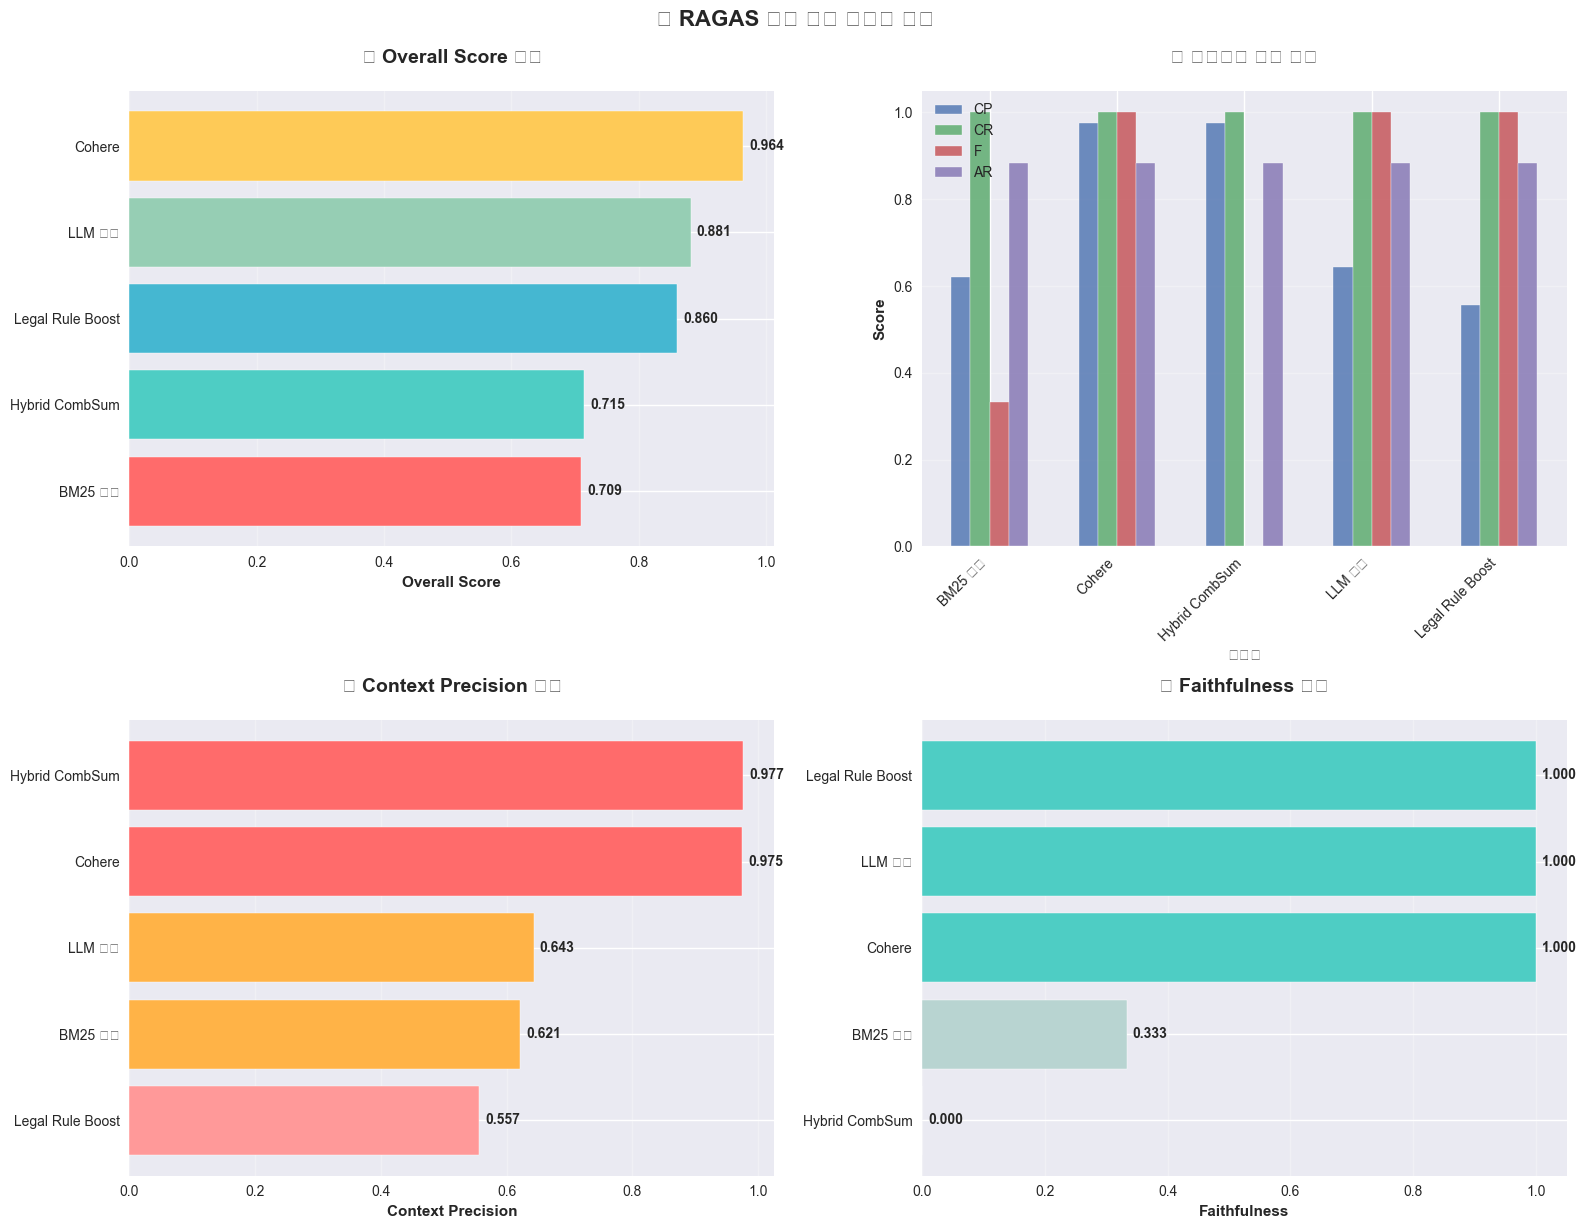

In [4]:
# 2. 막대 그래프 - 종합적인 성능 비교
def plot_bar_charts(df):
    """막대 그래프로 리랭커 성능 비교"""
    
    # 색상 팔레트
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    
    # 2x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1) Overall Score 막대 그래프
    ax1 = axes[0, 0]
    sorted_df = df.sort_values('overall_score', ascending=True)
    bars1 = ax1.barh(range(len(sorted_df)), sorted_df['overall_score'], color=colors)
    ax1.set_yticks(range(len(sorted_df)))
    ax1.set_yticklabels(sorted_df['reranker'])
    ax1.set_xlabel('Overall Score', fontweight='bold')
    ax1.set_title('🏆 Overall Score 순위', fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # 값 표시
    for i, (bar, value) in enumerate(zip(bars1, sorted_df['overall_score'])):
        ax1.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontweight='bold')
    
    # 2) 모든 메트릭 그룹별 막대 그래프
    ax2 = axes[0, 1]
    metrics = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
    metric_names = ['CP', 'CR', 'F', 'AR']
    
    x = np.arange(len(df))
    width = 0.15
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        offset = (i - len(metrics)/2 + 0.5) * width
        bars = ax2.bar(x + offset, df[metric], width, label=name, alpha=0.8)
    
    ax2.set_xlabel('리랭커', fontweight='bold')
    ax2.set_ylabel('Score', fontweight='bold')
    ax2.set_title('📊 메트릭별 성능 비교', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['reranker'], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3) Context Precision 세부 비교
    ax3 = axes[1, 0]
    sorted_cp = df.sort_values('context_precision', ascending=True)
    bars3 = ax3.barh(range(len(sorted_cp)), sorted_cp['context_precision'], 
                     color=['#FF6B6B' if x > 0.8 else '#FFB347' if x > 0.6 else '#FF9999' 
                            for x in sorted_cp['context_precision']])
    ax3.set_yticks(range(len(sorted_cp)))
    ax3.set_yticklabels(sorted_cp['reranker'])
    ax3.set_xlabel('Context Precision', fontweight='bold')
    ax3.set_title('🎯 Context Precision 성능', fontsize=14, fontweight='bold', pad=20)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 값 표시
    for i, (bar, value) in enumerate(zip(bars3, sorted_cp['context_precision'])):
        ax3.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontweight='bold')
    
    # 4) Faithfulness 세부 비교
    ax4 = axes[1, 1]
    sorted_f = df.sort_values('faithfulness', ascending=True)
    bars4 = ax4.barh(range(len(sorted_f)), sorted_f['faithfulness'], 
                     color=['#4ECDC4' if x > 0.8 else '#96CEB4' if x > 0.5 else '#B8D4D1' 
                            for x in sorted_f['faithfulness']])
    ax4.set_yticks(range(len(sorted_f)))
    ax4.set_yticklabels(sorted_f['reranker'])
    ax4.set_xlabel('Faithfulness', fontweight='bold')
    ax4.set_title('✅ Faithfulness 성능', fontsize=14, fontweight='bold', pad=20)
    ax4.grid(True, alpha=0.3, axis='x')
    
    # 값 표시
    for i, (bar, value) in enumerate(zip(bars4, sorted_f['faithfulness'])):
        ax4.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('📊 RAGAS 성능 막대 그래프 분석', fontsize=16, fontweight='bold', y=1.02)
    plt.savefig('ragas_bar_charts.png', dpi=300, bbox_inches='tight')
    plt.show()

# 막대 그래프 생성
plot_bar_charts(ragas_df)


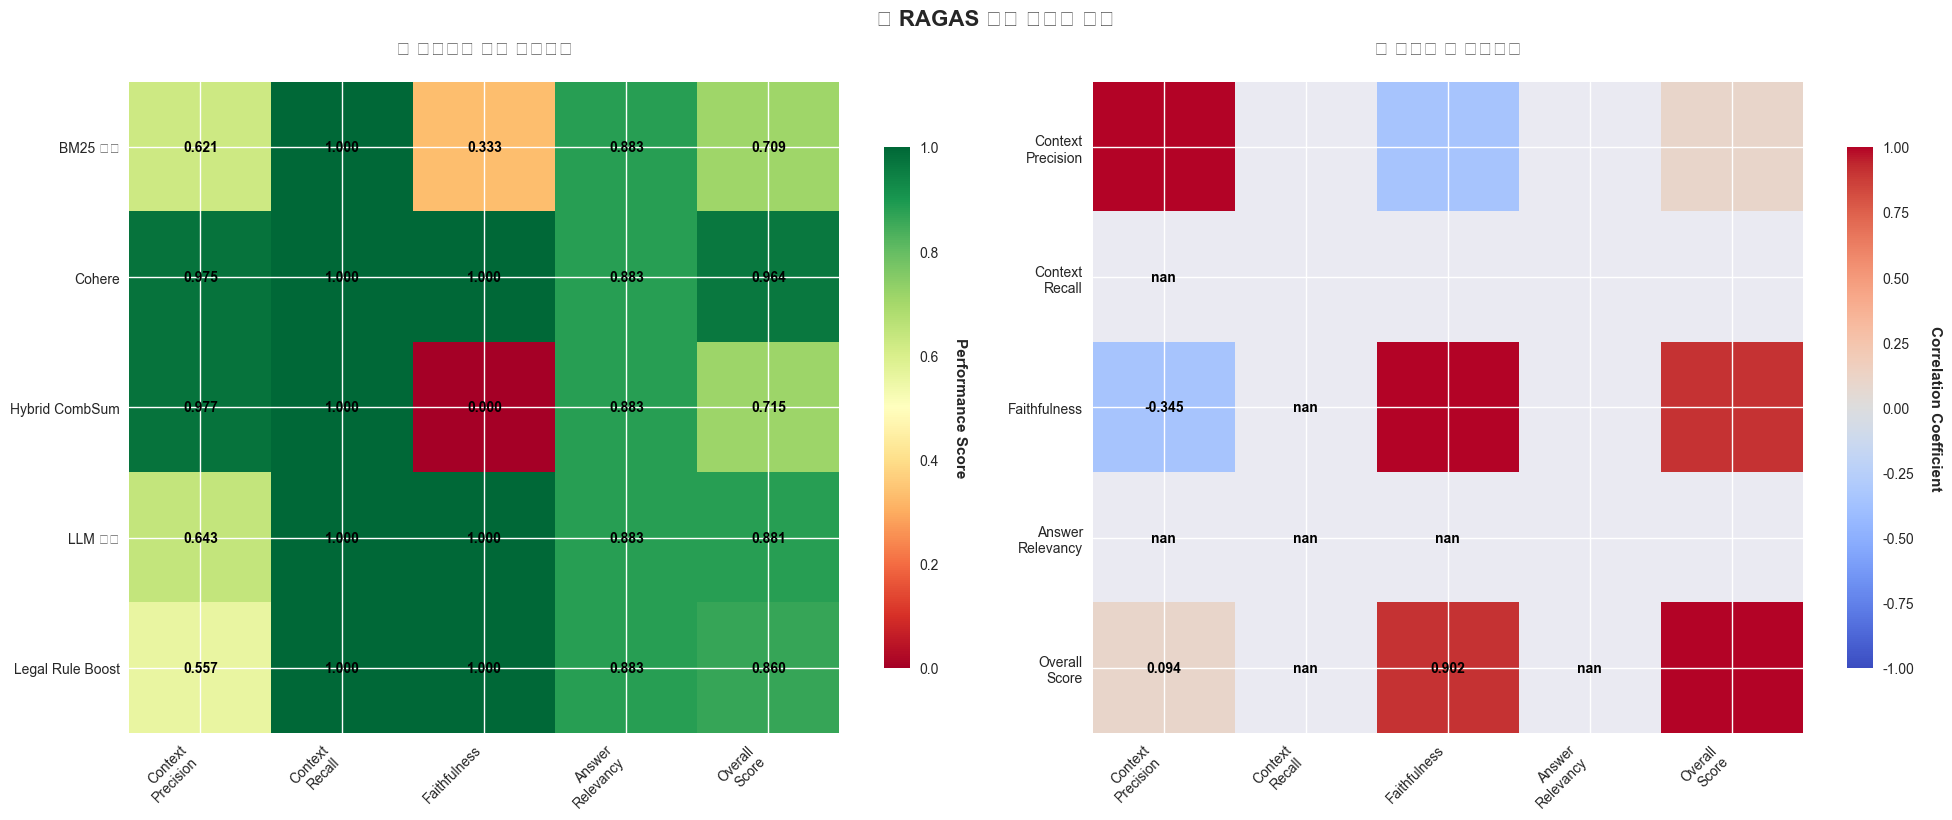


📊 메트릭 간 상관관계 분석:
• Context
Precision ↔ Context
Recall: nan (약한 음의 상관관계)
• Context
Precision ↔ Faithfulness: -0.345 (중간 음의 상관관계)
• Context
Precision ↔ Answer
Relevancy: nan (약한 음의 상관관계)
• Context
Precision ↔ Overall
Score: 0.094 (약한 양의 상관관계)
• Context
Recall ↔ Faithfulness: nan (약한 음의 상관관계)
• Context
Recall ↔ Answer
Relevancy: nan (약한 음의 상관관계)
• Context
Recall ↔ Overall
Score: nan (약한 음의 상관관계)
• Faithfulness ↔ Answer
Relevancy: nan (약한 음의 상관관계)
• Faithfulness ↔ Overall
Score: 0.902 (강한 양의 상관관계)
• Answer
Relevancy ↔ Overall
Score: nan (약한 음의 상관관계)


In [5]:
# 3. 히트맵 (혼동행렬 스타일) - 메트릭 간 상관관계 및 성능 매트릭스
def plot_heatmaps(df):
    """히트맵으로 성능 매트릭스 및 상관관계 시각화"""
    
    # 2x1 서브플롯 생성
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1) 성능 매트릭스 히트맵
    ax1 = axes[0]
    
    # 데이터 준비 (리랭커 x 메트릭)
    metrics = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy', 'overall_score']
    metric_names = ['Context\nPrecision', 'Context\nRecall', 'Faithfulness', 'Answer\nRelevancy', 'Overall\nScore']
    
    # 성능 매트릭스 생성
    performance_matrix = df[metrics].values
    
    # 히트맵 생성
    im1 = ax1.imshow(performance_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # 축 설정
    ax1.set_xticks(range(len(metric_names)))
    ax1.set_xticklabels(metric_names, rotation=45, ha='right')
    ax1.set_yticks(range(len(df)))
    ax1.set_yticklabels(df['reranker'])
    ax1.set_title('🎯 리랭커별 성능 매트릭스', fontsize=14, fontweight='bold', pad=20)
    
    # 값 표시
    for i in range(len(df)):
        for j in range(len(metrics)):
            text = ax1.text(j, i, f'{performance_matrix[i, j]:.3f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    # 컬러바
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Performance Score', rotation=270, labelpad=20, fontweight='bold')
    
    # 2) 메트릭 간 상관관계 히트맵
    ax2 = axes[1]
    
    # 상관관계 계산
    correlation_matrix = df[metrics].corr()
    
    # 히트맵 생성
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스크
    im2 = ax2.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    
    # 축 설정
    ax2.set_xticks(range(len(metric_names)))
    ax2.set_xticklabels(metric_names, rotation=45, ha='right')
    ax2.set_yticks(range(len(metric_names)))
    ax2.set_yticklabels(metric_names)
    ax2.set_title('🔗 메트릭 간 상관관계', fontsize=14, fontweight='bold', pad=20)
    
    # 값 표시
    for i in range(len(metrics)):
        for j in range(len(metrics)):
            if not mask[i, j]:  # 하삼각만 표시
                text = ax2.text(j, i, f'{correlation_matrix.iloc[i, j]:.3f}',
                               ha="center", va="center", color="black", fontweight='bold')
    
    # 컬러바
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('🔥 RAGAS 성능 히트맵 분석', fontsize=16, fontweight='bold', y=1.02)
    plt.savefig('ragas_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 상관관계 분석 출력
    print("\n📊 메트릭 간 상관관계 분석:")
    print("=" * 50)
    for i in range(len(metrics)):
        for j in range(i+1, len(metrics)):
            corr_val = correlation_matrix.iloc[i, j]
            corr_strength = "강한" if abs(corr_val) > 0.7 else "중간" if abs(corr_val) > 0.3 else "약한"
            corr_direction = "양의" if corr_val > 0 else "음의"
            print(f"• {metric_names[i]} ↔ {metric_names[j]}: {corr_val:.3f} ({corr_strength} {corr_direction} 상관관계)")

# 히트맵 생성
plot_heatmaps(ragas_df)


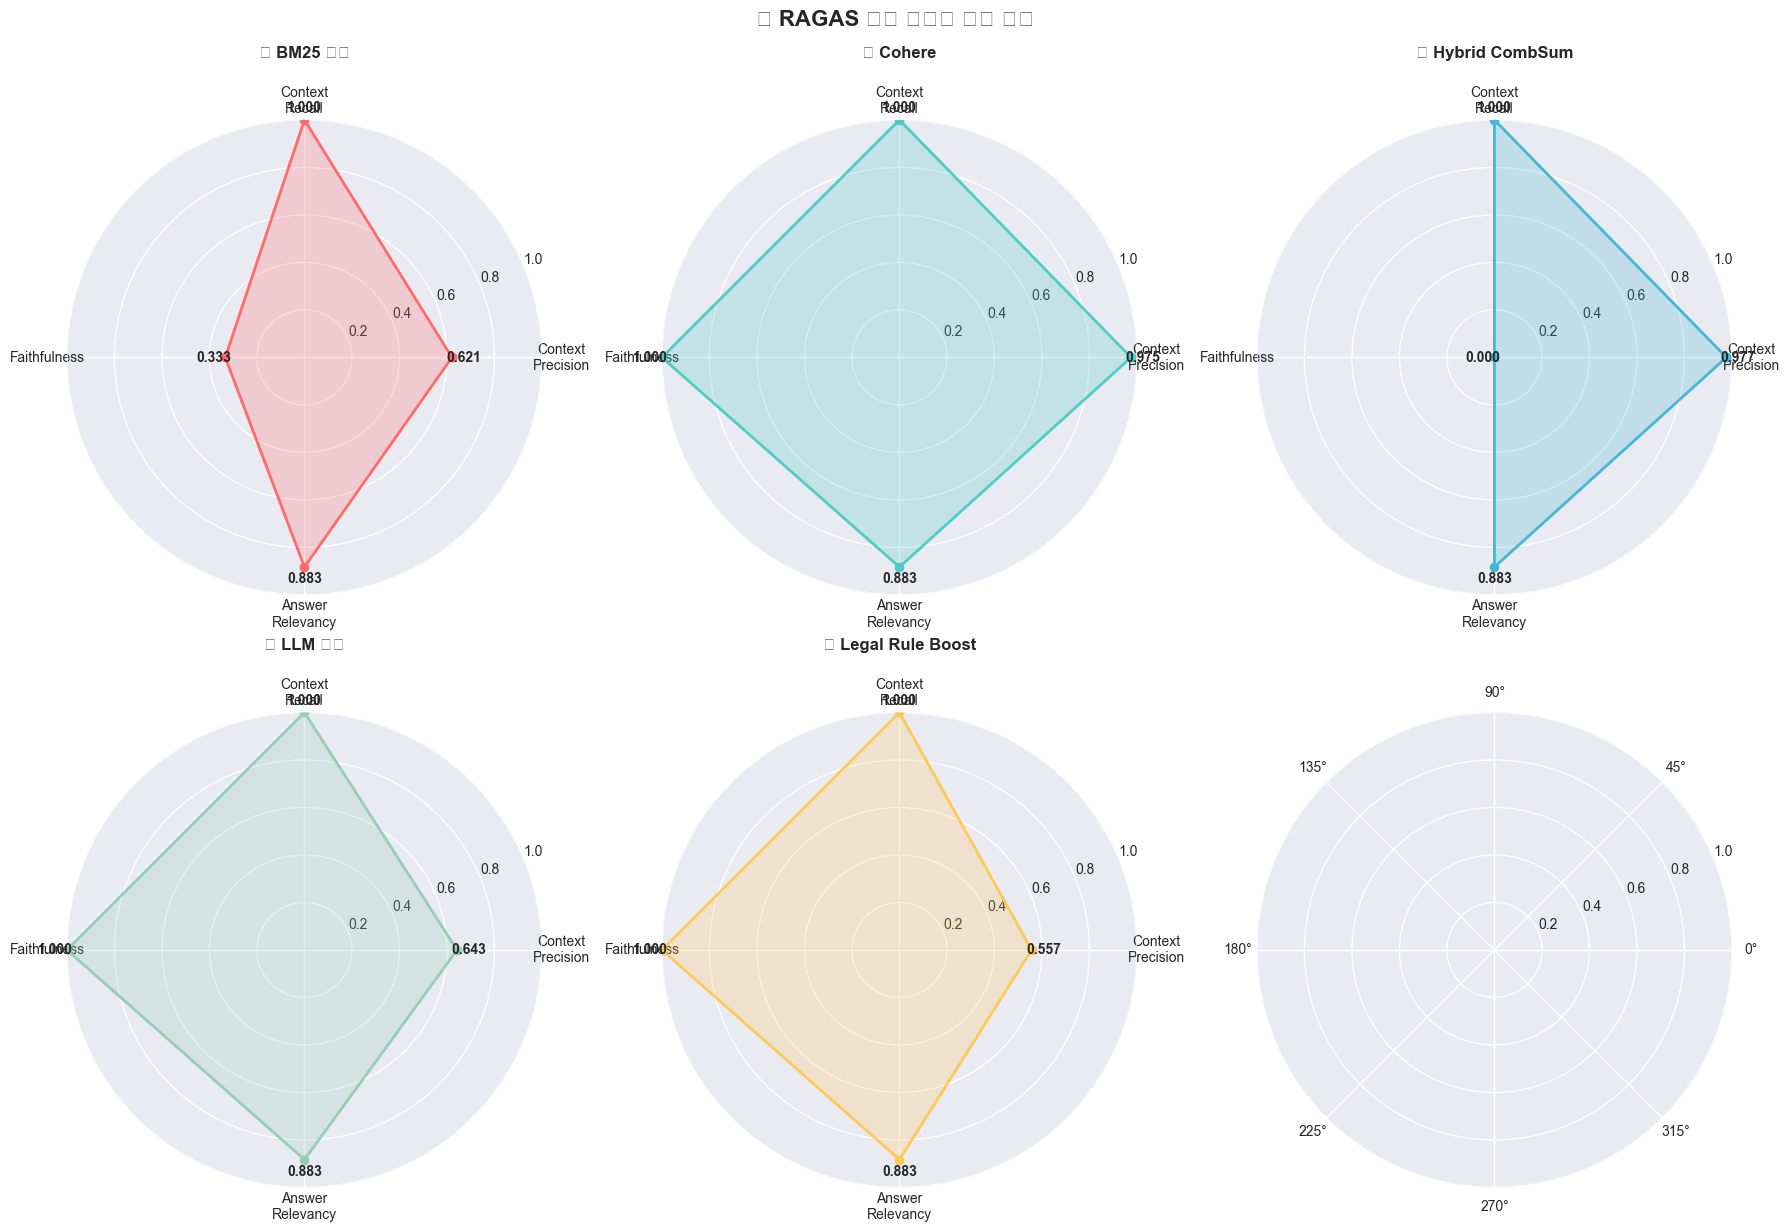

In [6]:
# 4. 레이더 차트 - 다차원 성능 비교
def plot_radar_charts(df):
    """레이더 차트로 리랭커 성능의 다차원 비교"""
    
    from math import pi
    
    # 메트릭 설정
    metrics = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
    metric_labels = ['Context\nPrecision', 'Context\nRecall', 'Faithfulness', 'Answer\nRelevancy']
    
    # 각도 계산
    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]  # 원형 완성
    
    # 색상 설정
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    
    # 서브플롯 생성 (2x3)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
    axes = axes.flatten()
    
    # 각 리랭커별 레이더 차트
    for i, (idx, row) in enumerate(df.iterrows()):
        if i < 6:  # 5개 리랭커 + 1개 종합
            ax = axes[i]
            
            if i < 5:  # 개별 리랭커
                # 데이터 준비
                values = [row[metric] for metric in metrics]
                values += values[:1]  # 원형 완성
                
                # 레이더 차트 그리기
                ax.plot(angles, values, 'o-', linewidth=2, label=row['reranker'], color=colors[i])
                ax.fill(angles, values, alpha=0.25, color=colors[i])
                
                # 축 설정
                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(metric_labels)
                ax.set_ylim(0, 1)
                ax.set_title(f"📊 {row['reranker']}", fontsize=12, fontweight='bold', pad=20)
                ax.grid(True)
                
                # 값 표시
                for angle, value in zip(angles[:-1], values[:-1]):
                    ax.text(angle, value + 0.05, f'{value:.3f}', 
                           ha='center', va='center', fontsize=10, fontweight='bold')
            
            else:  # 종합 비교
                ax = axes[5]
                
                # 모든 리랭커 데이터
                for j, (idx, row) in enumerate(df.iterrows()):
                    values = [row[metric] for metric in metrics]
                    values += values[:1]
                    
                    ax.plot(angles, values, 'o-', linewidth=2, 
                           label=row['reranker'], color=colors[j], alpha=0.8)
                    ax.fill(angles, values, alpha=0.1, color=colors[j])
                
                # 축 설정
                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(metric_labels)
                ax.set_ylim(0, 1)
                ax.set_title("🔄 전체 리랭커 비교", fontsize=12, fontweight='bold', pad=20)
                ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
                ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle('🎯 RAGAS 성능 레이더 차트 분석', fontsize=16, fontweight='bold', y=1.02)
    plt.savefig('ragas_radar_charts.png', dpi=300, bbox_inches='tight')
    plt.show()

# 레이더 차트 생성
plot_radar_charts(ragas_df)


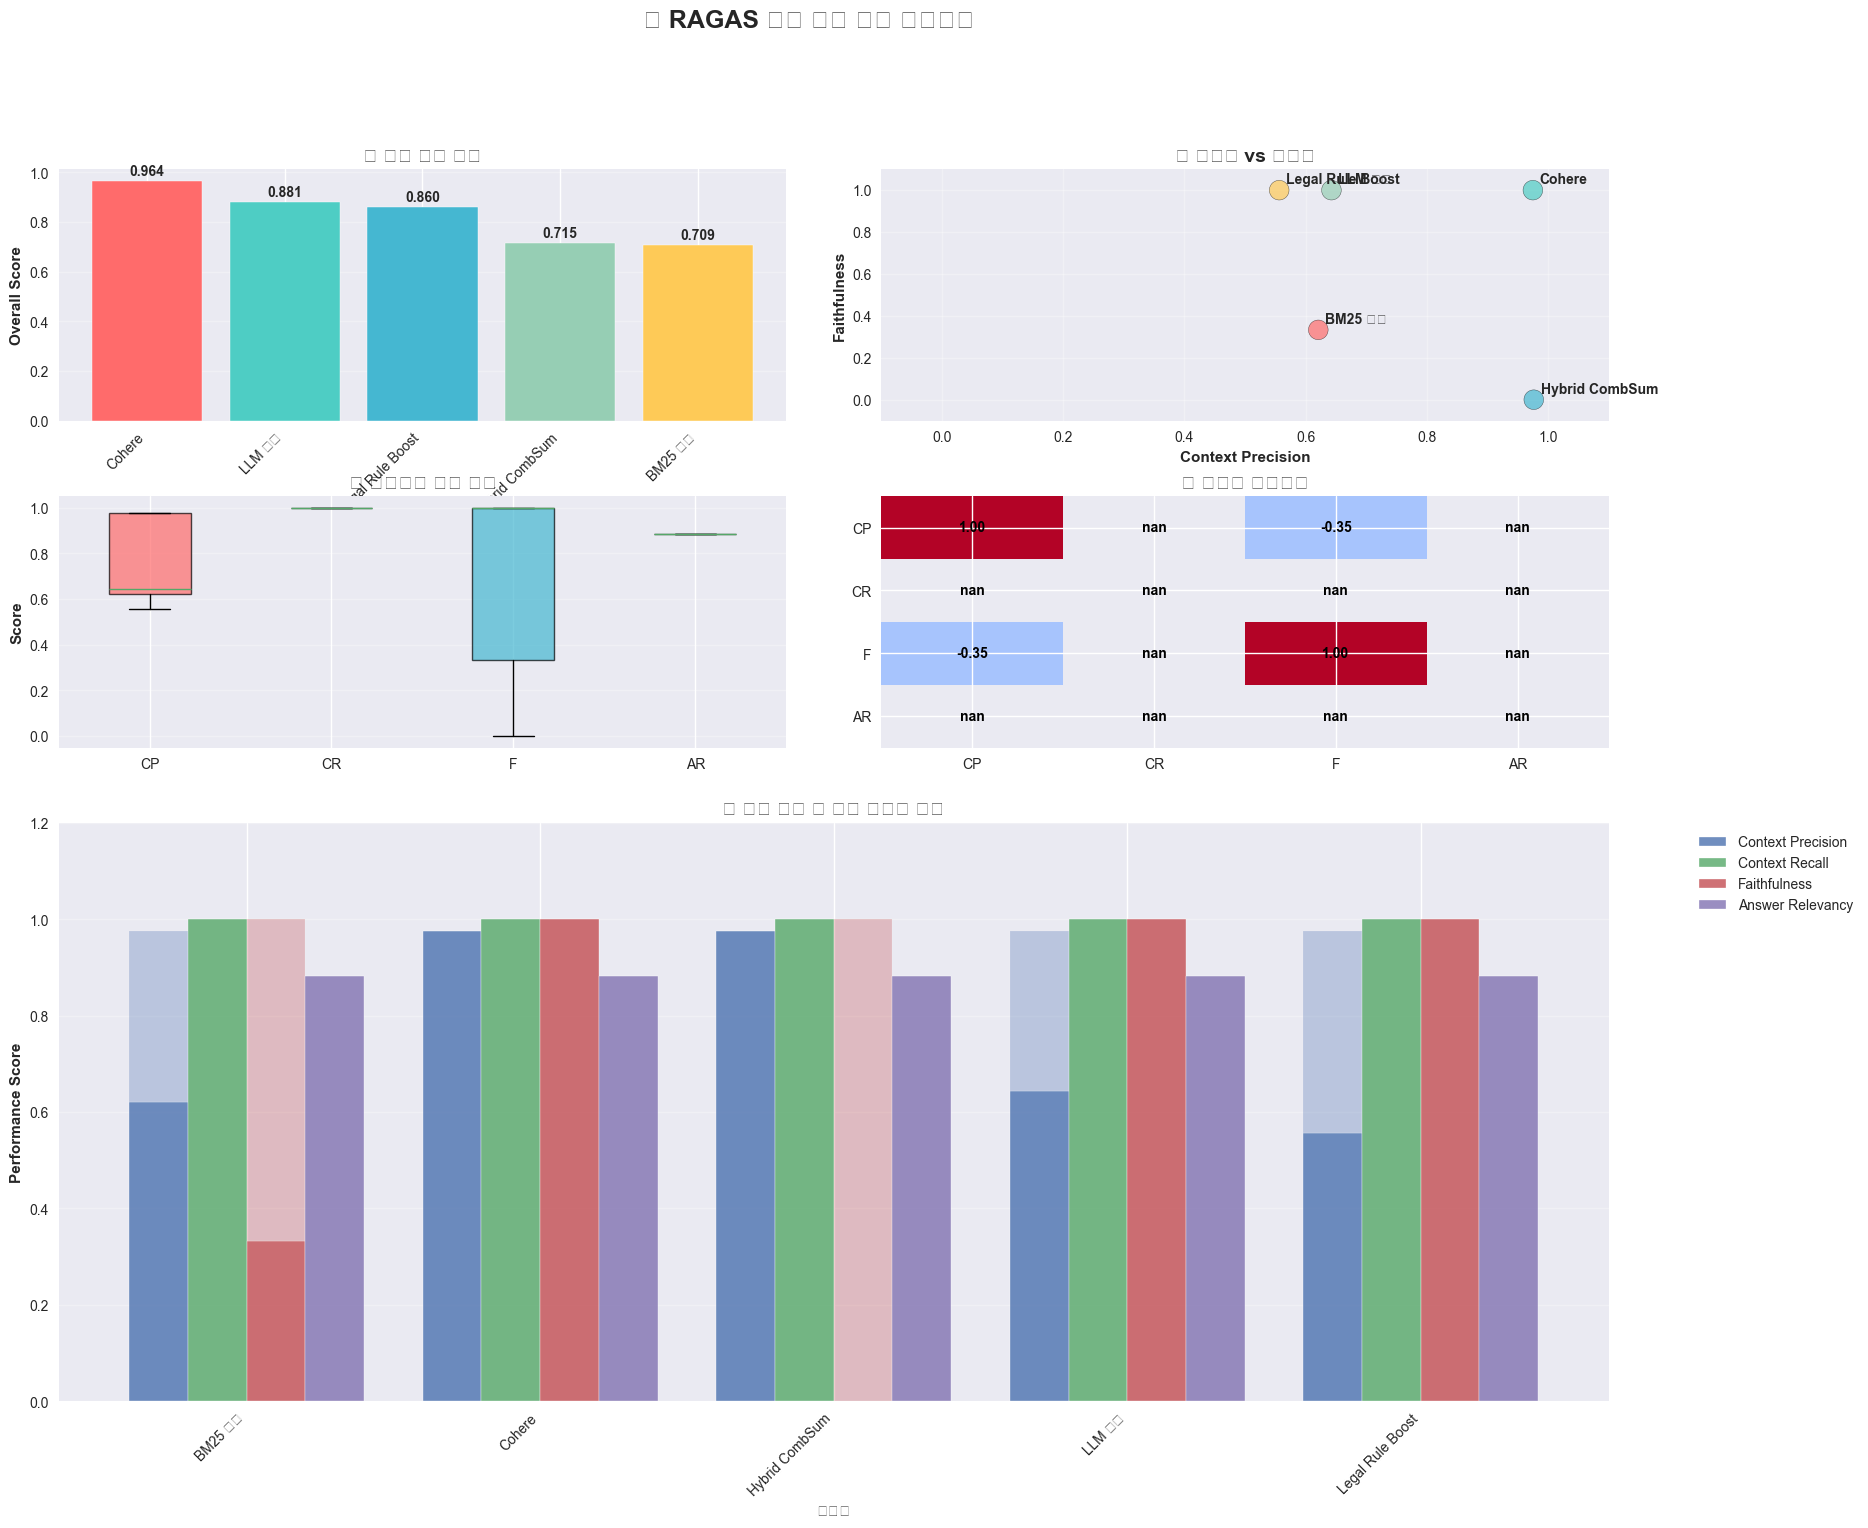

In [7]:
# 5. 성능 분석 대시보드 - 종합적인 시각화
def plot_comprehensive_dashboard(df):
    """종합적인 성능 분석 대시보드"""
    
    # 큰 피겐 생성
    fig = plt.figure(figsize=(20, 16))
    
    # 그리드 레이아웃 설정
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # 1) 전체 순위 (좌상단)
    ax1 = fig.add_subplot(gs[0, :2])
    sorted_df = df.sort_values('overall_score', ascending=False)
    bars = ax1.bar(range(len(sorted_df)), sorted_df['overall_score'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
    ax1.set_xticks(range(len(sorted_df)))
    ax1.set_xticklabels(sorted_df['reranker'], rotation=45, ha='right')
    ax1.set_ylabel('Overall Score', fontweight='bold')
    ax1.set_title('🏆 전체 성능 순위', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for i, (bar, value) in enumerate(zip(bars, sorted_df['overall_score'])):
        ax1.text(bar.get_x() + bar.get_width()/2, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 2) Context Precision vs Faithfulness 산점도 (우상단)
    ax2 = fig.add_subplot(gs[0, 2:])
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    scatter = ax2.scatter(df['context_precision'], df['faithfulness'], 
                         c=colors[:len(df)], s=200, alpha=0.7, edgecolors='black')
    
    # 리랭커 이름 표시
    for i, (idx, row) in enumerate(df.iterrows()):
        ax2.annotate(row['reranker'], 
                    (row['context_precision'], row['faithfulness']),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=10, fontweight='bold')
    
    ax2.set_xlabel('Context Precision', fontweight='bold')
    ax2.set_ylabel('Faithfulness', fontweight='bold')
    ax2.set_title('🎯 정확도 vs 신뢰도', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-0.1, 1.1)
    ax2.set_ylim(-0.1, 1.1)
    
    # 3) 성능 분포 박스플롯 (좌중단)
    ax3 = fig.add_subplot(gs[1, :2])
    metrics_data = [df[metric].values for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']]
    box_plot = ax3.boxplot(metrics_data, labels=['CP', 'CR', 'F', 'AR'], patch_artist=True)
    
    # 박스 색상 설정
    box_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    for patch, color in zip(box_plot['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_ylabel('Score', fontweight='bold')
    ax3.set_title('📊 메트릭별 성능 분포', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4) 메트릭 상관관계 히트맵 (우중단)
    ax4 = fig.add_subplot(gs[1, 2:])
    metrics = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
    corr_matrix = df[metrics].corr()
    
    im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    ax4.set_xticks(range(len(metrics)))
    ax4.set_xticklabels(['CP', 'CR', 'F', 'AR'])
    ax4.set_yticks(range(len(metrics)))
    ax4.set_yticklabels(['CP', 'CR', 'F', 'AR'])
    ax4.set_title('🔗 메트릭 상관관계', fontsize=14, fontweight='bold')
    
    # 상관계수 값 표시
    for i in range(len(metrics)):
        for j in range(len(metrics)):
            ax4.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                    ha="center", va="center", color="black", fontweight='bold')
    
    # 5) 성능 향상 포텐셜 분석 (하단 전체)
    ax5 = fig.add_subplot(gs[2:, :])
    
    # 각 메트릭별 최대값 대비 현재 성능 비율
    metrics = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
    x = np.arange(len(df))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        offset = (i - len(metrics)/2 + 0.5) * width
        values = df[metric].values
        max_val = values.max()
        improvement_potential = max_val - values
        
        # 현재 성능
        bars1 = ax5.bar(x + offset, values, width, label=f'{metric.replace("_", " ").title()}', alpha=0.8)
        
        # 개선 포텐셜 (스택)
        bars2 = ax5.bar(x + offset, improvement_potential, width, bottom=values, 
                       alpha=0.3, color=bars1[0].get_facecolor())
    
    ax5.set_xlabel('리랭커', fontweight='bold')
    ax5.set_ylabel('Performance Score', fontweight='bold')
    ax5.set_title('📈 성능 현황 및 개선 포텐셜 분석', fontsize=14, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(df['reranker'], rotation=45, ha='right')
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.set_ylim(0, 1.2)
    
    plt.suptitle('🚀 RAGAS 성능 종합 분석 대시보드', fontsize=18, fontweight='bold', y=0.98)
    plt.savefig('ragas_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

# 종합 대시보드 생성
plot_comprehensive_dashboard(ragas_df)


In [8]:
# 6. 성능 분석 리포트 생성
def generate_performance_report(df):
    """성능 분석 리포트 생성 및 출력"""
    
    print("="*80)
    print("🏆 RAGAS 기반 리랭커 성능 분석 리포트")
    print("="*80)
    
    # 1. 전체 순위
    print("\n📊 1. 전체 성능 순위 (Overall Score 기준)")
    print("-"*50)
    sorted_df = df.sort_values('overall_score', ascending=False)
    for i, (idx, row) in enumerate(sorted_df.iterrows()):
        print(f"{i+1:2d}위. {row['reranker']:<20} : {row['overall_score']:.4f}")
    
    # 2. 메트릭별 1위
    print("\n🥇 2. 메트릭별 최고 성능")
    print("-"*50)
    metrics = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
    metric_names = ['Context Precision', 'Context Recall', 'Faithfulness', 'Answer Relevancy']
    
    for metric, name in zip(metrics, metric_names):
        best_idx = df[metric].idxmax()
        best_value = df.loc[best_idx, metric]
        best_reranker = df.loc[best_idx, 'reranker']
        print(f"• {name:<18} : {best_reranker} ({best_value:.4f})")
    
    # 3. 성능 간격 분석
    print("\n📈 3. 성능 격차 분석")
    print("-"*50)
    for metric, name in zip(metrics, metric_names):
        max_val = df[metric].max()
        min_val = df[metric].min()
        gap = max_val - min_val
        print(f"• {name:<18} : 최고 {max_val:.4f} - 최저 {min_val:.4f} = 격차 {gap:.4f}")
    
    # 4. 균형성 분석
    print("\n⚖️ 4. 성능 균형성 분석 (표준편차 기준)")
    print("-"*50)
    for idx, row in df.iterrows():
        values = [row[metric] for metric in metrics]
        std_dev = np.std(values)
        mean_val = np.mean(values)
        balance_score = 1 - (std_dev / mean_val) if mean_val > 0 else 0
        print(f"• {row['reranker']:<20} : 균형점수 {balance_score:.4f} (편차: {std_dev:.4f})")
    
    # 5. 추천 사항
    print("\n💡 5. 리랭커 선택 추천")
    print("-"*50)
    
    best_overall = sorted_df.iloc[0]
    best_cp = df.loc[df['context_precision'].idxmax()]
    best_f = df.loc[df['faithfulness'].idxmax()]
    
    print(f"• 종합 성능 우선 : {best_overall['reranker']} (Overall: {best_overall['overall_score']:.4f})")
    print(f"• 검색 정확도 우선: {best_cp['reranker']} (CP: {best_cp['context_precision']:.4f})")
    print(f"• 신뢰성 우선    : {best_f['reranker']} (F: {best_f['faithfulness']:.4f})")
    
    # 6. 상관관계 분석
    print("\n🔗 6. 메트릭 간 상관관계")
    print("-"*50)
    corr_matrix = df[metrics].corr()
    
    high_corrs = []
    for i in range(len(metrics)):
        for j in range(i+1, len(metrics)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                direction = "양의" if corr_val > 0 else "음의"
                high_corrs.append((metric_names[i], metric_names[j], corr_val, direction))
    
    if high_corrs:
        for m1, m2, corr, direction in high_corrs:
            print(f"• {m1} ↔ {m2}: {corr:.3f} ({direction} 상관관계)")
    else:
        print("• 강한 상관관계 (|r| > 0.5) 없음")
    
    print("\n" + "="*80)
    print("✅ 리포트 생성 완료!")
    print("="*80)

# 성능 분석 리포트 생성
generate_performance_report(ragas_df)


🏆 RAGAS 기반 리랭커 성능 분석 리포트

📊 1. 전체 성능 순위 (Overall Score 기준)
--------------------------------------------------
 1위. Cohere               : 0.9644
 2위. LLM 기본               : 0.8814
 3위. Legal Rule Boost     : 0.8598
 4위. Hybrid CombSum       : 0.7148
 5위. BM25 기본              : 0.7093

🥇 2. 메트릭별 최고 성능
--------------------------------------------------
• Context Precision  : Hybrid CombSum (0.9765)
• Context Recall     : BM25 기본 (1.0000)
• Faithfulness       : Cohere (1.0000)
• Answer Relevancy   : BM25 기본 (0.8827)

📈 3. 성능 격차 분석
--------------------------------------------------
• Context Precision  : 최고 0.9765 - 최저 0.5566 = 격차 0.4199
• Context Recall     : 최고 1.0000 - 최저 1.0000 = 격차 0.0000
• Faithfulness       : 최고 1.0000 - 최저 0.0000 = 격차 1.0000
• Answer Relevancy   : 최고 0.8827 - 최저 0.8827 = 격차 0.0000

⚖️ 4. 성능 균형성 분석 (표준편차 기준)
--------------------------------------------------
• BM25 기본              : 균형점수 0.6380 (편차: 0.2568)
• Cohere               : 균형점수 0.9499 (편차: 0.0483)
• Hybrid 

In [9]:
# 7. 결과 저장 및 정리
def save_results(df):
    """결과를 CSV 파일로 저장하고 정리"""
    
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. 정리된 결과 저장
    output_filename = f"RAGAS_Final_Results_{timestamp}.csv"
    df.to_csv(output_filename, index=False, encoding='utf-8-sig')
    print(f"✅ 최종 결과 저장: {output_filename}")
    
    # 2. 메트릭별 순위 저장
    ranking_data = []
    metrics = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy', 'overall_score']
    
    for metric in metrics:
        sorted_df = df.sort_values(metric, ascending=False)
        for i, (idx, row) in enumerate(sorted_df.iterrows()):
            ranking_data.append({
                'metric': metric,
                'rank': i + 1,
                'reranker': row['reranker'],
                'score': row[metric]
            })
    
    ranking_df = pd.DataFrame(ranking_data)
    ranking_filename = f"RAGAS_Rankings_{timestamp}.csv"
    ranking_df.to_csv(ranking_filename, index=False, encoding='utf-8-sig')
    print(f"✅ 순위 데이터 저장: {ranking_filename}")
    
    # 3. 생성된 이미지 파일 목록
    image_files = [
        'ragas_line_charts.png',
        'ragas_bar_charts.png', 
        'ragas_heatmaps.png',
        'ragas_radar_charts.png',
        'ragas_comprehensive_dashboard.png'
    ]
    
    print(f"\n📁 생성된 시각화 파일:")
    for img_file in image_files:
        print(f"• {img_file}")
    
    print(f"\n🎉 모든 분석 및 시각화 완료!")
    print(f"📊 총 {len(df)}개 리랭커, {len(metrics)}개 메트릭 분석")
    
    return output_filename, ranking_filename

# 결과 저장
final_file, ranking_file = save_results(ragas_df)
print(f"\n최종 결과 파일: {final_file}")
print(f"순위 데이터 파일: {ranking_file}")


✅ 최종 결과 저장: RAGAS_Final_Results_20250917_173542.csv
✅ 순위 데이터 저장: RAGAS_Rankings_20250917_173542.csv

📁 생성된 시각화 파일:
• ragas_line_charts.png
• ragas_bar_charts.png
• ragas_heatmaps.png
• ragas_radar_charts.png
• ragas_comprehensive_dashboard.png

🎉 모든 분석 및 시각화 완료!
📊 총 5개 리랭커, 5개 메트릭 분석

최종 결과 파일: RAGAS_Final_Results_20250917_173542.csv
순위 데이터 파일: RAGAS_Rankings_20250917_173542.csv
